In [1]:
# Forcefully remove the old 'gym' package to avoid conflicts in Colab
%pip uninstall -y gym
%pip install -qr https://raw.githubusercontent.com/anton-dergunov/hugging-face-deep-rl/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from huggingface_hub import HfApi, create_repo, notebook_login, hf_hub_download
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
from pathlib import Path
import hashlib
import imageio
import os
import json
import tempfile

In [2]:
import warnings

# This filter handles the "pkg_resources is deprecated" warning from Pygame
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pygame')
warnings.filterwarnings("ignore", category=UserWarning, module="pygame")

# This filter handles all the "Deprecated call to `pkg_resources.declare_namespace`" warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pkg_resources')

In [3]:
MODEL_PATH = "models/ppo_cartpole.zip"
VIDEO_PATH = "videos/ppo_cartpole.mp4"
LOGS_PATH = "logs/ppo_cartpole"

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

In [22]:
ENV_ID = "CartPole-v1"

# TODO Provide constants for all other repeated variables here

### Create Environment

TODO Describe the environment

https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [5]:
# Create a vectorized environment (parallel environments)
# "CartPole-v1" is a simple classic control task
# n_envs=4 means we run 4 copies of the environment in parallel
vec_env = make_vec_env(ENV_ID, n_envs=4)

### Define & Train PPO Agent

[PPO Algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

Training statistics:

- `rollout`:
    - `ep_len_mean`: Average episode length (steps before pole falls)
    - `ep_len_mean`: Average reward (same as length here)
- `time`:
    - `fps`: Training speed (frames per second)
    - `iterations`: Number of iterations?
    - `time_elapsed`: Time in seconds since the beginning of training
    - `total_timesteps`: Total number of timesteps. PPO collects in chunks of 8192 timesteps (with 4 envs × ~2048 steps)
- `train`:
    - `approx_kl`: KL divergence between new and old policy
    - `clip_fraction`: % of updates where PPO clipped gradients
    - `clip_range`: Value of clipping factor?
    - `entropy_loss`: Policy entropy (exploration). Lower → more deterministic.
    - `explained_variance`: How well value function predicts returns. 1 = perfect
    - `learning_rate`: Current learning rate value
    - `loss`: Current total loss value
    - `n_updates`: Number of gradient updates applied so far?
    - `policy_gradient_loss`: Current value of the policy gradient loss (its value does not have much meaning)
    - `value_loss`: Current value for the value function loss

Details: [Explanation of logger output](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output)

FIXME Fix the warning below
```
/Users/anton/Dropbox/src/hugging-face-deep-rl/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
```

In [6]:
# Create vectorized env (n_envs=4) and wrap with VecMonitor to save monitor.csv
vec_env = VecMonitor(vec_env, filename=os.path.join(LOGS_PATH, "monitor.csv"))

# Initialize PPO model with TensorBoard logging
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",
    tensorboard_log=LOGS_PATH   # TensorBoard will write here
)

# Train the agent
model.learn(total_timesteps=25_000)

# Save the trained model
model.save(MODEL_PATH)

/Users/anton/Dropbox/src/hugging-face-deep-rl/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Using cpu device
Logging to logs/ppo_cartpole/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    fps             | 19275    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.6        |
|    ep_rew_mean          | 31.6        |
| time/                   |             |
|    fps                  | 6852        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014421191 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_varia

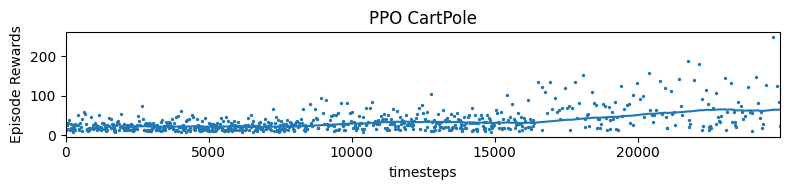

In [7]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH], 25_000, results_plotter.X_TIMESTEPS, "PPO CartPole")
plt.show()

TODO Make the cell below optional, so that it is disabled and/or not runs when I do "Run All"?

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ppo_cartpole

### Load Trained Model

In [8]:
# Load the saved model
model = PPO.load(MODEL_PATH, device="cpu")

### Evaluate Policy

TODO What is n_eval_episodes in the code below?

In [9]:
def evaluate_model(model, env_id, n_eval_episodes=10):
    env = Monitor(gym.make(env_id))
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
    env.close()
    return {
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_eval_episodes": n_eval_episodes
    }

In [10]:
metrics = evaluate_model(model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(431.5), 'std_reward': np.float64(81.81106282160134), 'n_eval_episodes': 10}


### Run Trained Agent

In [11]:
def record_cartpole_video(model, video_path, steps=1000):
    # Set the video driver to a dummy one to prevent window creation
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    
    # Create env with video recording enabled
    env = gym.make(ENV_ID, render_mode="rgb_array")
    
    try:
        frames = []
        obs, info = env.reset()
        episode, step = 0, 0

        for _ in range(steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            
            # Render the frame from the environment
            frame = env.render()

            # --- Overlay text (small, anti-aliased) ---
            cv2.putText(frame, f"Ep: {episode}", (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(frame, f"Step: {step}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            frames.append(frame)
            step += 1

            if terminated or truncated:
                episode += 1
                step = 0
                obs, info = env.reset()
        
        # Save the collected frames to a single video file
        os.makedirs(os.path.dirname(video_path), exist_ok=True)
        imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
        print(f"Saved video to {video_path}")

    finally:
        # Ensure the environment is closed to release all resources
        env.close()

In [12]:
# Save to video
record_cartpole_video(model, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/ppo_cartpole.mp4


In [13]:
Video(VIDEO_PATH, embed=True)

### Hugging Face: Store Credentials

To create and manage tokens:
https://huggingface.co/settings/tokens

Make sure to use the token with write role!

TODO Do I need to run this over and over again? Probably not! How can I make this below cell optional then? And not runnable when I say "Run All"?

In [14]:
# Store Hugging Face token
notebook_login()

# Remember login credentials on disk
!git config --global credential.helper store

### Hugging Face: Upload the Model

TODO Describe the README file (model card) and provide the links to HF web site

In [15]:
def generate_readme(repo_name, env_id, algo, metrics):
    yaml_metadata = f"""---
library_name: stable-baselines3
tags:
- reinforcement-learning
- deep-reinforcement-learning
- sb3
- {env_id}
model-index:
- name: {repo_name}
  results:
  - task:
      type: reinforcement-learning
      name: Reinforcement Learning
    dataset:
      name: {env_id}
      type: gym
    metrics:
    - type: mean_reward
      value: {metrics['mean_reward']:.2f}
      name: Mean Reward
    - type: std_reward
      value: {metrics['std_reward']:.2f}
      name: Std Reward
---
"""

    readme = f"""{yaml_metadata}

# {repo_name}

This is a reinforcement learning agent trained with **{algo}** on **{env_id}** using [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3).

## Usage

```python
from huggingface_sb3 import load_from_hub

model = load_from_hub("{repo_name}")
obs = model.get_env().reset()

for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, info = model.get_env().step(action)
    if done:
        obs = model.get_env().reset()
```
"""

    return readme

In [ ]:
def upload_sb3_model(model, repo_id, model_name, model_architecture, env_id,
                     metrics, commit_message="Upload SB3 model", video_path=None):
    api = HfApi()

    def upload_file(path_or_fileobj, path_in_repo, repo_id, commit_message):
        print(f"Uploading {path_in_repo}...")
        api.upload_file(
            path_or_fileobj=path_or_fileobj,
            path_in_repo=path_in_repo,
            repo_id=repo_id,
            commit_message=commit_message
        )

    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir = Path(os.path.abspath(tmpdir))

        # 1. Save model
        model_path = tmpdir / "model.zip"
        print(f"Saving the model to {model_path}...")
        model.save(model_path)

        # Output the size and hash of the saved model
        model_size = os.path.getsize(model_path)
        with open(model_path, "rb") as f:
            model_hash = hashlib.sha256(f.read()).hexdigest()
        print(f"Model size: {model_size / 1024:.2f} KB")
        print(f"Model SHA256: {model_hash}")

        # Try loading the file we just created as a verification step
        try:
            PPO.load(model_path, device="cpu")
        except Exception as e:
            print(f"❌ Verification failed. The saved file is corrupted: {e}")
            # Do not proceed if verification fails
            raise

        # 2. Create metadata
        metadata = {
            "model_name": model_name,
            "model_architecture": model_architecture,
            "env_id": env_id,
        }
        metadata_path = tmpdir / "metadata.json"
        with open(metadata_path, "w") as f:
            json.dump(metadata, f)

        # 3. Create README (model card)
        readme_path = tmpdir / "README.md"
        readme_text = generate_readme(repo_id, env_id, model_architecture, metrics)
        with open(readme_path, "w") as f:
            f.write(readme_text)

        # 4. Create repo if missing
        try:
            create_repo(repo_id, exist_ok=True)
        except Exception as e:
            print(f"Repo already exists or could not be created: {e}")

        # 5. Upload all files
        for file in [model_path, metadata_path, readme_path]:
            upload_file(
                path_or_fileobj=file,
                path_in_repo=os.path.basename(file),
                repo_id=repo_id,
                commit_message=commit_message,
            )

        # 6. Upload video separately
        if video_path:
            upload_file(
                path_or_fileobj=video_path,
                path_in_repo=f"replay.mp4",
                repo_id=repo_id,
                commit_message="Add demo video"
            )

    print(f"\n✅ Upload complete! View the model at:")
    print(f"https://huggingface.co/{repo_id}")

In [17]:
upload_sb3_model(
    model=model,
    repo_id="AntonDergunov/CartPole_PPO",
    model_name="CartPole_PPO",
    model_architecture="PPO",
    env_id="CartPole-v1",
    metrics=metrics,
    video_path=VIDEO_PATH
)

Model size: 140.12 KB
Model SHA256: f8a2d2eed6ad8da9d364ecbe7c55b4f7f40092cb241682dab16004c527c8f45e
✅ Local model saved and verified successfully.
Uploading model.zip...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...9s3wh0000gn/T/tmp6qe9kpdi/model.zip: 100%|##########|  143kB /  143kB            

Uploading metadata.json...


No files have been modified since last commit. Skipping to prevent empty commit.


Uploading README.md...
Uploading replay.mp4...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  videos/ppo_cartpole.mp4               : 100%|##########|  123kB /  123kB            

  videos/ppo_cartpole.mp4               : 100%|##########|  123kB /  123kB            


✅ Upload complete! View your model at:
https://huggingface.co/AntonDergunov/CartPole_PPO


### Hugging Face: Load the Model

TODO Move this code to a function to load the model

TODO Also change the readme file to provide the updated instructions

In [ ]:
print("Loading the model from HF...")  # TODO Provide the repo_id and filename in the message
model_path = hf_hub_download(
    repo_id="AntonDergunov/CartPole_PPO",
    filename="model.zip"
)

# Output the size and hash of the saved model
model_size = os.path.getsize(model_path)
with open(model_path, "rb") as f:
    model_hash = hashlib.sha256(f.read()).hexdigest()
print(f"Model size: {model_size / 1024:.2f} KB")
print(f"Model SHA256: {model_hash}")

model = PPO.load(model_path, device="cpu")

env = gym.make(ENV_ID)
obs, info = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

print("✅ Model loaded from Hugging Face and tested successfully!")

/Users/anton/.cache/huggingface/hub/models--AntonDergunov--CartPole_PPO/snapshots/41269da0f4bf769150ac089530e38a0ed92dad15/model.zip
Model size: 140.12 KB
Model SHA256: f8a2d2eed6ad8da9d364ecbe7c55b4f7f40092cb241682dab16004c527c8f45e
✅ Model loaded and tested successfully from Hugging Face!
